# topo-descriptors

A python library to compute DEM-based topographical descriptors.

## Usage

Let's install `topo-descriptors` with few additional packages that will help us
to run a simple example (remember to use a virtual environment):

In [1]:
%pip install topo-descriptors elevation rioxarray matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


The [elevation](https://github.com/bopen/elevation) package is an python library that
provides an easy access to global elevation data. Here we are going to clip the SRTM 30m
DEM around the Basodino region in southern Switzerland, around 46.4N 8.5E:

In [ ]:
!eio clip -o Basodino-30m-DEM.tif --bounds 8.2 46.30 8.6 46.55

In [2]:
import logging

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s %(name)-12s %(levelname)-8s %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

Now in python we can easily import the
`Basodino-30m-DEM.tif` file generated above:

2023-12-20 17:51:48,462 yaconfigobject INFO     Loading /prod/gve/home/mts/git/topo-descriptors/topo_descriptors/config/topo_descriptors.conf.
2023-12-20 17:51:48,463 yaconfigobject INFO     Loading configuration file: /prod/gve/home/mts/git/topo-descriptors/topo_descriptors/config/topo_descriptors.conf


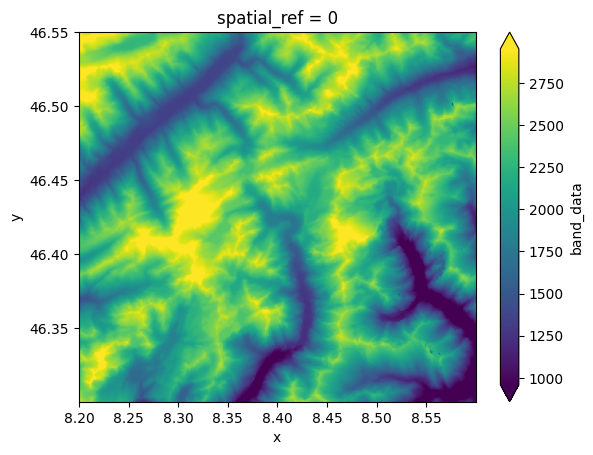

In [3]:
from topo_descriptors.helpers import get_dem_netcdf, scale_to_pixel

dem_ds = get_dem_netcdf("Basodino-30m-DEM.tif")
varname = list(dem_ds)[0]
dem_ds.attrs.update(crs="epsg:4326")
dem_ds[varname].plot(robust=True)

2023-12-20 17:51:53,624 topo_descriptors.helpers INFO     Computed in 0:00:00 (HH:mm:ss)


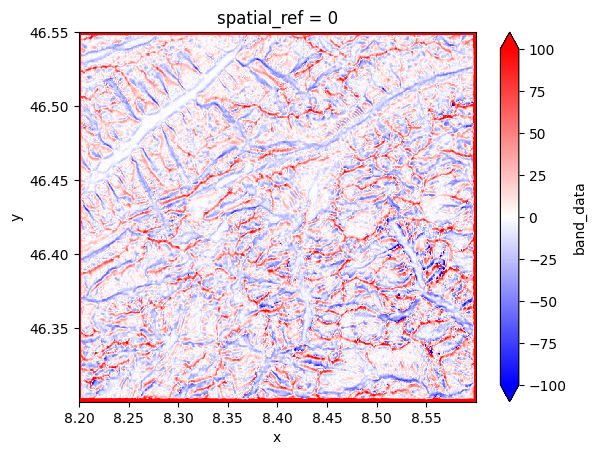

In [4]:
from topo_descriptors import topo

scale_meters = 500
scale_pixel, __ = scale_to_pixel(scale_meters, dem_ds)
topo.tpi(dem_ds[varname], scale_pixel).plot(vmin=-100, vmax=100, cmap="bwr")

The Sx is used to describe the horizon in a given direction and spatial scale.
In the example below we compute the Sx for a 0° azimuth (i.e., looking North)
and a radius of 500 meters.

2023-12-20 17:52:51,720 topo_descriptors.helpers INFO     Computed in 0:00:02 (HH:mm:ss)


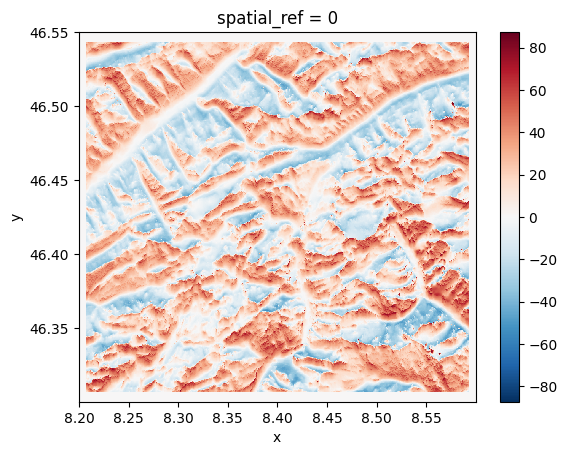

In [6]:
import xarray as xr

sx_500m = topo.sx(dem_ds, azimuth=0, radius=500)
xr.DataArray(sx_500m, coords=dem_ds.coords).plot.imshow()

Other topographical descriptors are available, such as slope, aspect, derivatives,
and more. As an example, below we show how to compute a range of descriptors for two
distinc spatial scales (200 and 2000 meters).

In [7]:
from pathlib import Path

output_dir = Path("out/")
output_dir.mkdir(exist_ok=True)

scales_meters = [200, 2000]
domain = {"x": slice(8.25, 8.55), "y": slice(46.50, 46.35)}

topo.compute_gradient(dem_ds, scales_meters, sig_ratios=1, crop=domain, outdir=output_dir)
topo.compute_std(dem_ds, scales_meters, crop=domain, outdir=output_dir)
topo.compute_tpi(dem_ds, scales_meters, crop=domain, outdir=output_dir)
topo.compute_sx(dem_ds, azimuth=0, radius=scales_meters[0], crop=domain, outdir=output_dir)
topo.compute_sx(dem_ds, azimuth=0, radius=scales_meters[1], crop=domain, outdir=output_dir)

2023-12-20 17:52:57,624 topo_descriptors.topo INFO     ***Starting gradients computation for scales [200, 2000] meters***
2023-12-20 17:52:57,918 topo_descriptors.topo INFO     Computing scale 200 meters with sigma ratio 1 ...
2023-12-20 17:52:57,970 topo_descriptors.helpers INFO     Computed in 0:00:00 (HH:mm:ss)
2023-12-20 17:52:57,995 topo_descriptors.helpers INFO     saved: out/topo_WE_DERIVATIVE_200M_SIGRATIO1.nc
2023-12-20 17:52:58,008 topo_descriptors.helpers INFO     saved: out/topo_SN_DERIVATIVE_200M_SIGRATIO1.nc
2023-12-20 17:52:58,021 topo_descriptors.helpers INFO     saved: out/topo_SLOPE_200M_SIGRATIO1.nc
2023-12-20 17:52:58,034 topo_descriptors.helpers INFO     saved: out/topo_ASPECT_200M_SIGRATIO1.nc
2023-12-20 17:52:58,035 topo_descriptors.topo INFO     Computing scale 2000 meters with sigma ratio 1 ...
2023-12-20 17:52:58,281 topo_descriptors.helpers INFO     Computed in 0:00:00 (HH:mm:ss)
2023-12-20 17:52:58,295 topo_descriptors.helpers INFO     saved: out/topo_WE_DER

Above, the output was written directly to disk, while in the cell below we show how 
to easly import the results and visualize them using xarray.

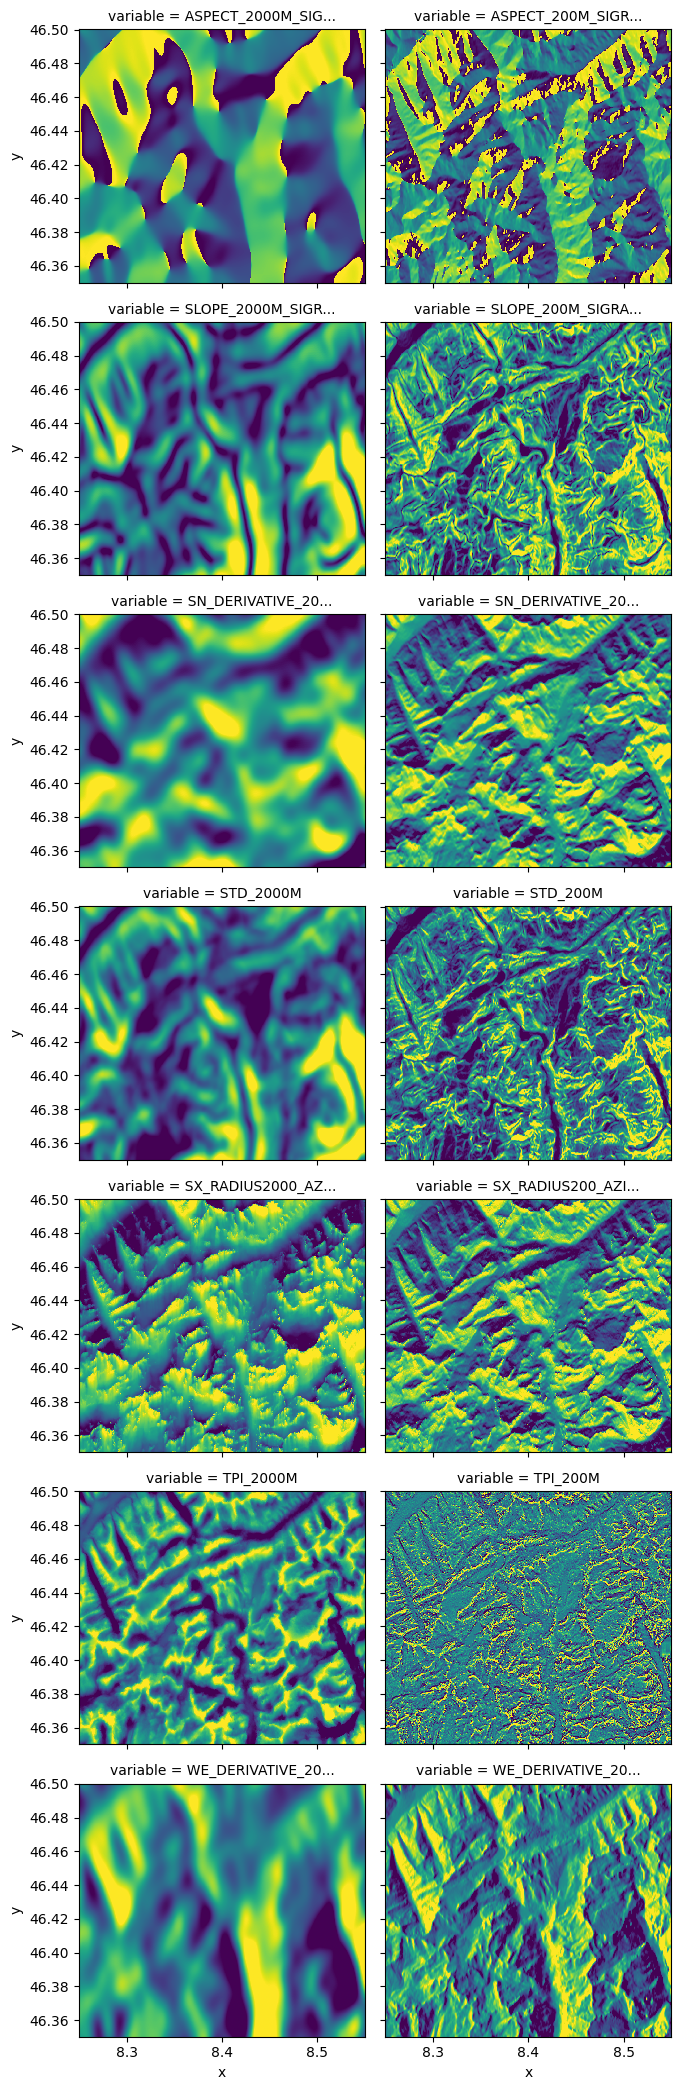

In [8]:
ds = xr.open_mfdataset(str(output_dir / "topo_*.nc"))
min_max = ds.quantile(q=[0.05, 0.95])
ds = (ds - min_max.isel(quantile=0)) / (
    min_max.isel(quantile=1) - min_max.isel(quantile=0)
)
ds.to_array().plot.imshow(
    col="variable",
    col_wrap=len(scales_meters),
    robust=True,
    add_colorbar=False,
    vmin=0,
    vmax=1,
)
ds.close()

## Build the README

To use this Jupyter Notebook to compile the markdown's version for GitHub, first install
the conda environment using the `environment.yaml` file:

```shell
conda env create -f environment.yaml
conda activate topo
```

Then generate the `README.md` by running:

```shell
jupyter nbconvert --execute --to markdown README.ipynb
```

The associated figures are saved in the `README_files/` folder.